In [1]:
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [106]:
batch_size = 16
epochs = 50
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [107]:
folder_path="drive/MyDrive/rared_images/"

In [108]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [109]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")

In [110]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [111]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'fear': 4021, 'surprise': 3200, 'disgust': 435, 'angry': 3799, 'neutral': 4947, 'happy': 6299, 'sad': 4957}
{'fear': 980, 'surprise': 787, 'disgust': 109, 'angry': 876, 'neutral': 1196, 'happy': 1668, 'sad': 1098}


In [112]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [113]:
plot_dist(train_dict, "Training data")

In [114]:
plot_dist(val_dict, "Validation data")

In [115]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [116]:
train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

Found 27658 images belonging to 7 classes.
Found 6714 images belonging to 7 classes.


In [117]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [118]:
# METRICS = [
#       tf.keras.metrics.Accuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]

In [120]:
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.6))
model.add(Dense(7,activation='softmax'))

In [124]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


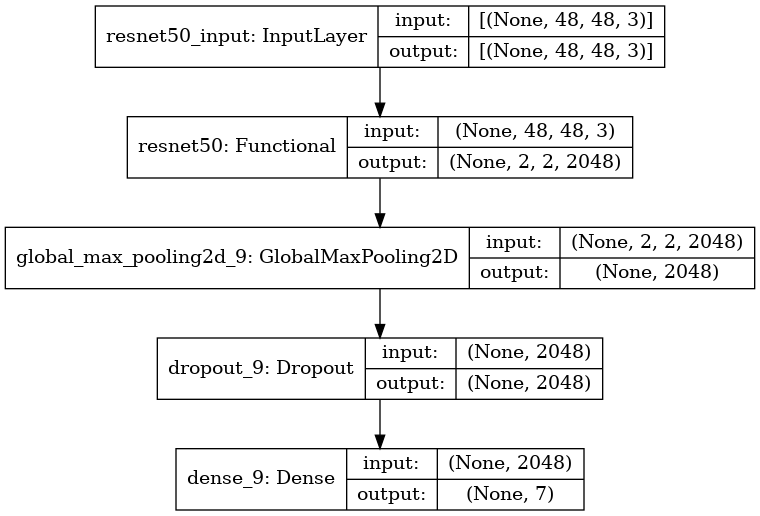

In [126]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [127]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


callbacks_list = [early_stopping,checkpoint]

In [128]:
history = model.fit(train_set, 
                    validation_data = val_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = val_set.n//val_set.batch_size,callbacks=callbacks_list)

Epoch 1/50
1728/1728 [==============================] - 82s 44ms/step - loss: 5.5309 - accuracy: 0.2692 - val_loss: 1.8463 - val_accuracy: 0.4095
Epoch 2/50
1728/1728 [==============================] - 76s 44ms/step - loss: 3.3623 - accuracy: 0.3874 - val_loss: 1.5708 - val_accuracy: 0.4493
Epoch 3/50
1728/1728 [==============================] - 76s 44ms/step - loss: 2.5300 - accuracy: 0.4494 - val_loss: 1.3134 - val_accuracy: 0.5119
Epoch 4/50
1728/1728 [==============================] - 75s 43ms/step - loss: 2.1930 - accuracy: 0.4825 - val_loss: 1.1972 - val_accuracy: 0.5546
Epoch 5/50
1728/1728 [==============================] - 74s 43ms/step - loss: 1.9906 - accuracy: 0.5302 - val_loss: 1.1856 - val_accuracy: 0.5743
Epoch 6/50
1728/1728 [==============================] - 75s 43ms/step - loss: 2.0959 - accuracy: 0.5132 - val_loss: 1.2546 - val_accuracy: 0.5421
Epoch 7/50
1728/1728 [==============================] - 74s 43ms/step - loss: 1.7886 - accuracy: 0.5701 - val_loss: 1.1333 -

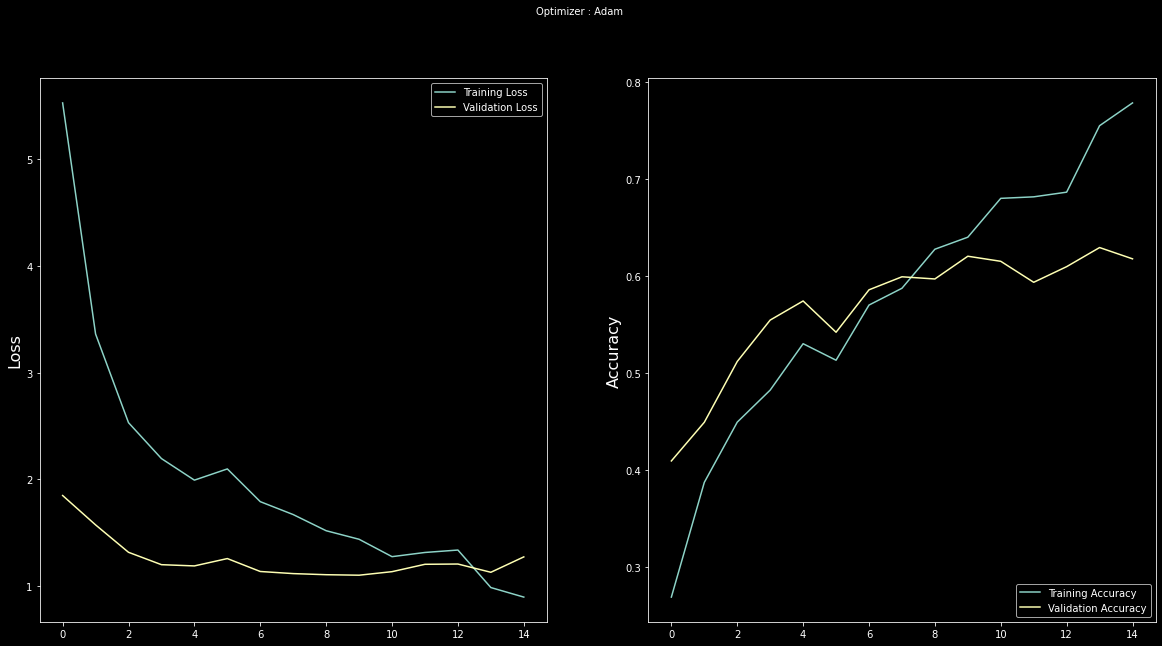

In [129]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



<Figure size 432x288 with 0 Axes>

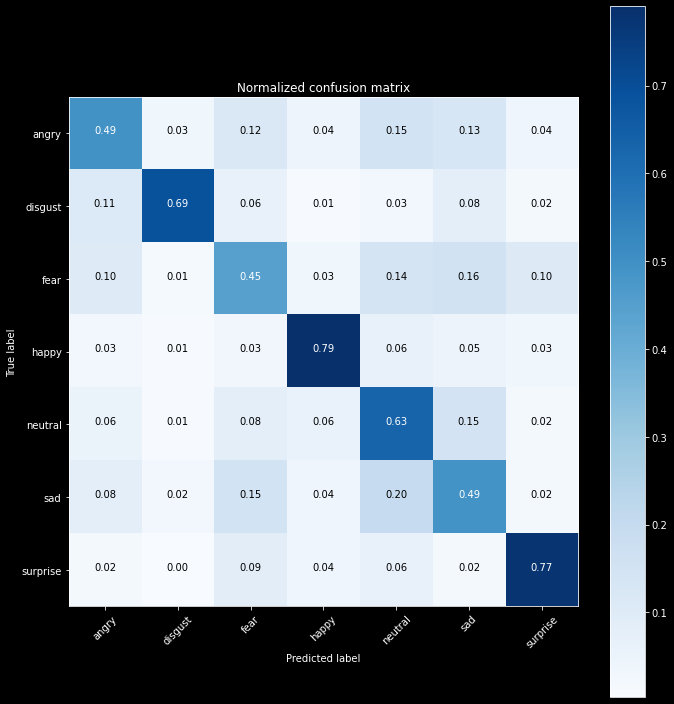

In [130]:
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [131]:
model_json = model.to_json()
with open("model_final_2.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_final_2.h5")
print("Saved model to disk")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Saved model to disk
